In [1]:
import pandas as pd 
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor


In [2]:
gdp = pd.read_csv(r"gdp.csv")
wti = pd.read_csv(r"wti.csv")
cpi = pd.read_csv(r"cpi.csv")
inflation = pd.read_csv(r"inflationrate.csv")
brent = pd.read_csv(r"brent.csv")
rgdp = pd.read_csv(r"rgdp.csv")
ppi = pd.read_csv(r"ppi.csv")
cpifuel = pd.read_csv(r"cpifuel.csv")

GDP data

In [3]:
gdp['DATE'] = pd.to_datetime(gdp['DATE'])
gdp = gdp.resample('M', on='DATE').sum()

Producer Price Index by Industry: Petroleum Lubricating Oil and Grease Manufacturing Data

In [4]:
ppi['DATE'] = pd.to_datetime(ppi['DATE'])
ppi = ppi.resample('M', on='DATE').sum()

Real GDP data

In [5]:
rgdp['DATE'] = pd.to_datetime(rgdp['DATE'])
rgdp = rgdp.resample('M', on='DATE').sum() 

Brent data

In [6]:
brent['DATE'] = pd.to_datetime(brent['DATE'])
brent = brent.resample('M', on='DATE').sum()

West Texas Intermediate (WTI)

In [7]:
wti['DATE'] = pd.to_datetime(wti['DATE'])
wti = wti.resample('M', on='DATE').sum()

CPI

In [8]:
cpi['DATE'] = pd.to_datetime(cpi['DATE'])
cpi = cpi.resample('M', on='DATE').sum()

Inflation rate

In [9]:
inflation['DATE'] = pd.to_datetime(inflation['DATE'])
inflation = inflation.resample('M', on='DATE').sum()

Consumer Price Index for All Urban Consumers: Fuel Oil and Other Fuels in U.S. City Average

In [10]:
cpifuel['DATE'] = pd.to_datetime(cpifuel['DATE'])
cpifuel = cpifuel.resample('M', on='DATE').sum()

Combining all the table data 

In [11]:
wticombined = wti
for df in [brent ,gdp, rgdp , cpi, inflation , ppi , cpifuel]:
    wticombined = pd.merge(wticombined, df, on='DATE', how='outer')

In [12]:
wticombined.head(13)

,WTISPLC,POILBREUSDM,GDP,GDPC1,CPIAUCSL,T10YIEM,PCU324191324191,CUSR0000SEHE
DATE,,,,,,,,
2003-01-31,32.94,30.808696,11174.129,14614.141,182.6,1.76,186.5,134.7
2003-02-28,35.87,32.662500,0.000,0.000,183.6,1.91,187.9,148.8
2003-03-31,33.55,30.168095,0.000,0.000,183.9,1.87,188.3,163.2
2003-04-30,28.25,25.035000,11312.766,14743.567,183.2,1.78,189.8,144.2
2003-05-31,28.14,25.714545,0.000,0.000,182.9,1.66,191.8,137.5
2003-06-30,30.72,27.566667,0.000,0.000,183.1,1.61,192.3,135.5
2003-07-31,30.76,28.503913,11566.669,14988.782,183.7,1.87,192.3,135.6
2003-08-31,31.59,29.718095,0.000,0.000,184.5,2.13,192.9,135.6
2003-09-30,28.29,27.044091,0.000,0.000,185.1,2.08,193.0,133.1


In [13]:
wticombined = wticombined.rename(columns={'WTISPLC': 'WTI Monthly','POILBREUSDM': 'Brent Monthly', 'GDPC1': 'Real GDP', 'T10YIEM': 'Inflation Rate', 'CPIAUCSL': 'CPI' , 'PCU324191324191':'Producer Price Index' , 'CUSR0000SEHE':'CPI Fuel'})


Handeling NaN values 

In [14]:
nan_counts = wticombined.isna().sum()

print("Number of NaN values in each column:")
print(nan_counts)

Number of NaN values in each column:
WTI Monthly             0
Brent Monthly           0
GDP                     2
Real GDP                2
CPI                     0
Inflation Rate          0
Producer Price Index    0
CPI Fuel                0
dtype: int64


In [15]:
wticombined.index = pd.to_datetime(wticombined.index)

wticombined = wticombined[wticombined.index >= '2003-01-01']

In [16]:
wticombined.head(10)

,WTI Monthly,Brent Monthly,GDP,Real GDP,CPI,Inflation Rate,Producer Price Index,CPI Fuel
DATE,,,,,,,,
2003-01-31,32.94,30.808696,11174.129,14614.141,182.6,1.76,186.5,134.7
2003-02-28,35.87,32.662500,0.000,0.000,183.6,1.91,187.9,148.8
2003-03-31,33.55,30.168095,0.000,0.000,183.9,1.87,188.3,163.2
2003-04-30,28.25,25.035000,11312.766,14743.567,183.2,1.78,189.8,144.2
2003-05-31,28.14,25.714545,0.000,0.000,182.9,1.66,191.8,137.5
2003-06-30,30.72,27.566667,0.000,0.000,183.1,1.61,192.3,135.5
2003-07-31,30.76,28.503913,11566.669,14988.782,183.7,1.87,192.3,135.6
2003-08-31,31.59,29.718095,0.000,0.000,184.5,2.13,192.9,135.6
2003-09-30,28.29,27.044091,0.000,0.000,185.1,2.08,193.0,133.1


In [17]:
wticombined.tail(10)

,WTI Monthly,Brent Monthly,GDP,Real GDP,CPI,Inflation Rate,Producer Price Index,CPI Fuel
DATE,,,,,,,,
2023-03-31,73.28,79.256522,0.000,0.000,301.744,2.30,641.721,383.785
2023-04-30,79.45,83.536000,27063.012,22225.350,303.032,2.27,635.493,382.466
2023-05-31,71.58,75.747391,0.000,0.000,303.365,2.21,636.061,366.167
2023-06-30,70.25,74.975000,0.000,0.000,304.003,2.20,637.573,362.490
2023-07-31,76.07,80.109048,27610.128,22490.692,304.628,2.30,635.425,370.104
2023-08-31,81.39,85.168261,0.000,0.000,306.187,2.34,634.873,395.957
2023-09-30,89.43,92.673333,0.000,0.000,307.288,2.34,627.385,411.343
2023-10-31,85.64,88.947727,27938.831,22672.859,307.531,2.39,630.503,396.278
2023-11-30,77.69,82.186364,NaN,NaN,308.024,2.30,631.266,392.414


In [18]:
print(wticombined[['WTI Monthly', 'Brent Monthly', 'Inflation Rate','GDP', 'Real GDP', 'CPI' ,'Producer Price Index' , 'CPI Fuel']].isna().sum())

WTI Monthly             0
Brent Monthly           0
Inflation Rate          0
GDP                     2
Real GDP                2
CPI                     0
Producer Price Index    0
CPI Fuel                0
dtype: int64


In [19]:
wticombined.head(13)

,WTI Monthly,Brent Monthly,GDP,Real GDP,CPI,Inflation Rate,Producer Price Index,CPI Fuel
DATE,,,,,,,,
2003-01-31,32.94,30.808696,11174.129,14614.141,182.6,1.76,186.5,134.7
2003-02-28,35.87,32.662500,0.000,0.000,183.6,1.91,187.9,148.8
2003-03-31,33.55,30.168095,0.000,0.000,183.9,1.87,188.3,163.2
2003-04-30,28.25,25.035000,11312.766,14743.567,183.2,1.78,189.8,144.2
2003-05-31,28.14,25.714545,0.000,0.000,182.9,1.66,191.8,137.5
2003-06-30,30.72,27.566667,0.000,0.000,183.1,1.61,192.3,135.5
2003-07-31,30.76,28.503913,11566.669,14988.782,183.7,1.87,192.3,135.6
2003-08-31,31.59,29.718095,0.000,0.000,184.5,2.13,192.9,135.6
2003-09-30,28.29,27.044091,0.000,0.000,185.1,2.08,193.0,133.1


After trimming the data now we have a data with very lees NaN values
The reason we trimmed the data is because the data missing was not because of randomness, it was because of lack of data during the years, filling them with imputed values will cause the model to be biased and give wrong readings.

In [20]:
nan_counts = wticombined.isna().sum()

print("Number of NaN values in each column:")
print(nan_counts)

Number of NaN values in each column:
WTI Monthly             0
Brent Monthly           0
GDP                     2
Real GDP                2
CPI                     0
Inflation Rate          0
Producer Price Index    0
CPI Fuel                0
dtype: int64


fill the NaN values

In [21]:
wticombined_filled = wticombined.fillna(df.mean())

In [22]:
wticombined_filled.tail()

,WTI Monthly,Brent Monthly,GDP,Real GDP,CPI,Inflation Rate,Producer Price Index,CPI Fuel
DATE,,,,,,,,
2023-08-31,81.39,85.168261,0.000,0.000,306.187,2.34,634.873,395.957
2023-09-30,89.43,92.673333,0.000,0.000,307.288,2.34,627.385,411.343
2023-10-31,85.64,88.947727,27938.831,22672.859,307.531,2.39,630.503,396.278
2023-11-30,77.69,82.186364,NaN,NaN,308.024,2.30,631.266,392.414
2023-12-31,71.90,77.540952,NaN,NaN,308.742,2.18,636.138,382.583


0 values are replaced with the help of linear interpolation along the index axis to fill missing values based on neighboring data points.

In [23]:
wticombined_filled[['WTI Monthly', 'Brent Monthly' ,'Inflation Rate','GDP', 'Real GDP', 'CPI' ,'Producer Price Index', 'CPI Fuel']] = wticombined_filled[['WTI Monthly', 'Brent Monthly','Inflation Rate','GDP', 'Real GDP', 'CPI','Producer Price Index', 'CPI Fuel']].replace(0, pd.np.nan).interpolate(method='linear')

C:\Users\Ashin Johnson\AppData\Local\Temp\ipykernel_15088\2212129366.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  wticombined_filled[['WTI Monthly', 'Brent Monthly' ,'Inflation Rate','GDP', 'Real GDP', 'CPI' ,'Producer Price Index', 'CPI Fuel']] = wticombined_filled[['WTI Monthly', 'Brent Monthly','Inflation Rate','GDP', 'Real GDP', 'CPI','Producer Price Index', 'CPI Fuel']].replace(0, pd.np.nan).interpolate(method='linear')


In [24]:
wticombined_filled

,WTI Monthly,Brent Monthly,GDP,Real GDP,CPI,Inflation Rate,Producer Price Index,CPI Fuel
DATE,,,,,,,,
2003-01-31,32.94,30.808696,11174.129000,14614.141000,182.600,1.76,186.500,134.700
2003-02-28,35.87,32.662500,11220.341333,14657.283000,183.600,1.91,187.900,148.800
2003-03-31,33.55,30.168095,11266.553667,14700.425000,183.900,1.87,188.300,163.200
2003-04-30,28.25,25.035000,11312.766000,14743.567000,183.200,1.78,189.800,144.200
2003-05-31,28.14,25.714545,11397.400333,14825.305333,182.900,1.66,191.800,137.500
...,...,...,...,...,...,...,...,...
2023-08-31,81.39,85.168261,27719.695667,22551.414333,306.187,2.34,634.873,395.957
2023-09-30,89.43,92.673333,27829.263333,22612.136667,307.288,2.34,627.385,411.343
2023-10-31,85.64,88.947727,27938.831000,22672.859000,307.531,2.39,630.503,396.278


In [25]:
summary_stats = wticombined_filled.describe()
summary_stats

,WTI Monthly,Brent Monthly,GDP,Real GDP,CPI,Inflation Rate,Producer Price Index,CPI Fuel
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,68.235556,72.133955,17806.979071,18330.955528,233.579143,2.083056,399.313861,279.742794
std,23.357764,26.371010,4322.306836,2159.425761,31.194197,0.402923,112.747104,73.697399
min,16.550000,25.035000,11174.129000,14614.141000,182.600000,0.250000,186.500000,131.600000
25%,49.787500,52.435171,14540.914417,16591.989000,212.414750,1.830000,327.750000,233.059500
50%,65.540000,68.734565,16916.312833,17835.320167,232.918500,2.180000,420.900000,276.147500
75%,86.350000,92.237138,20744.275500,20160.949167,252.276750,2.360000,456.450000,333.793750
max,133.930000,133.585217,27938.831000,22672.859000,308.742000,2.880000,648.561000,512.249000


Data Visualisation
Histogram

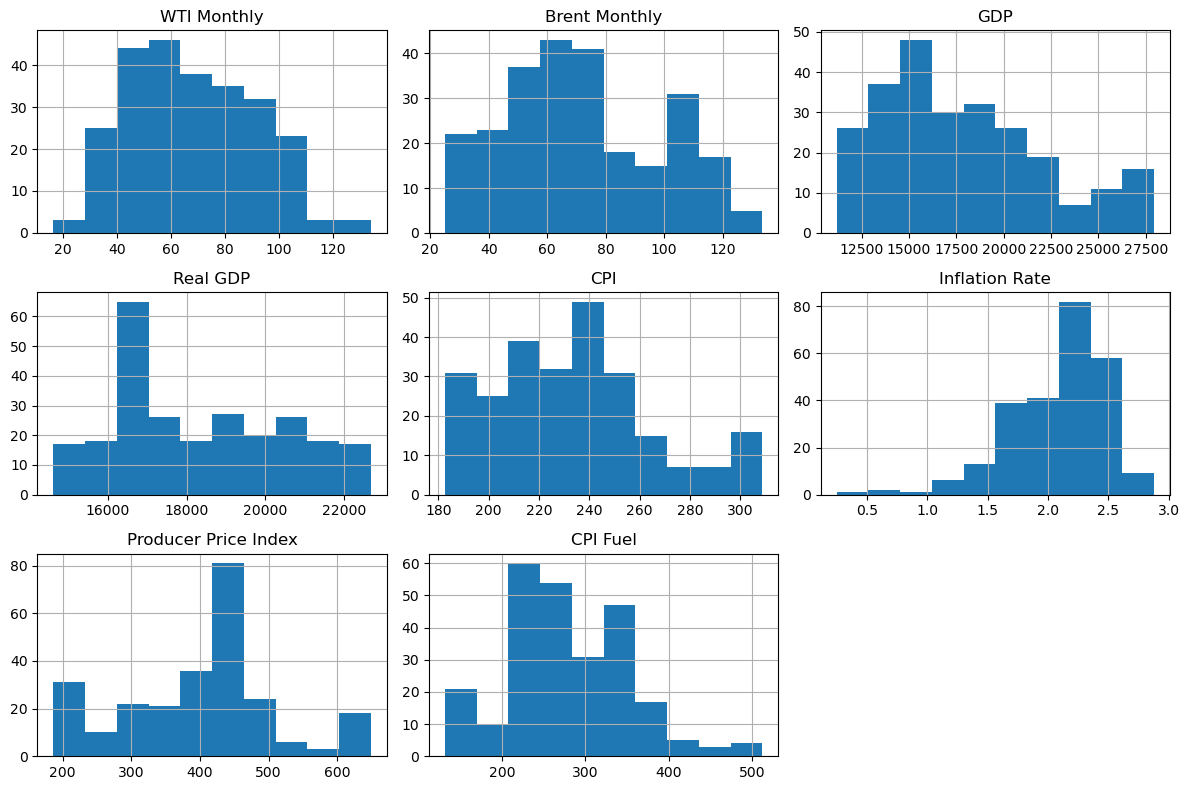

In [26]:
wticombined_filled.hist(figsize=(12, 8))
plt.tight_layout()
plt.show()

Scatterplot 

c:\Users\Ashin Johnson\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


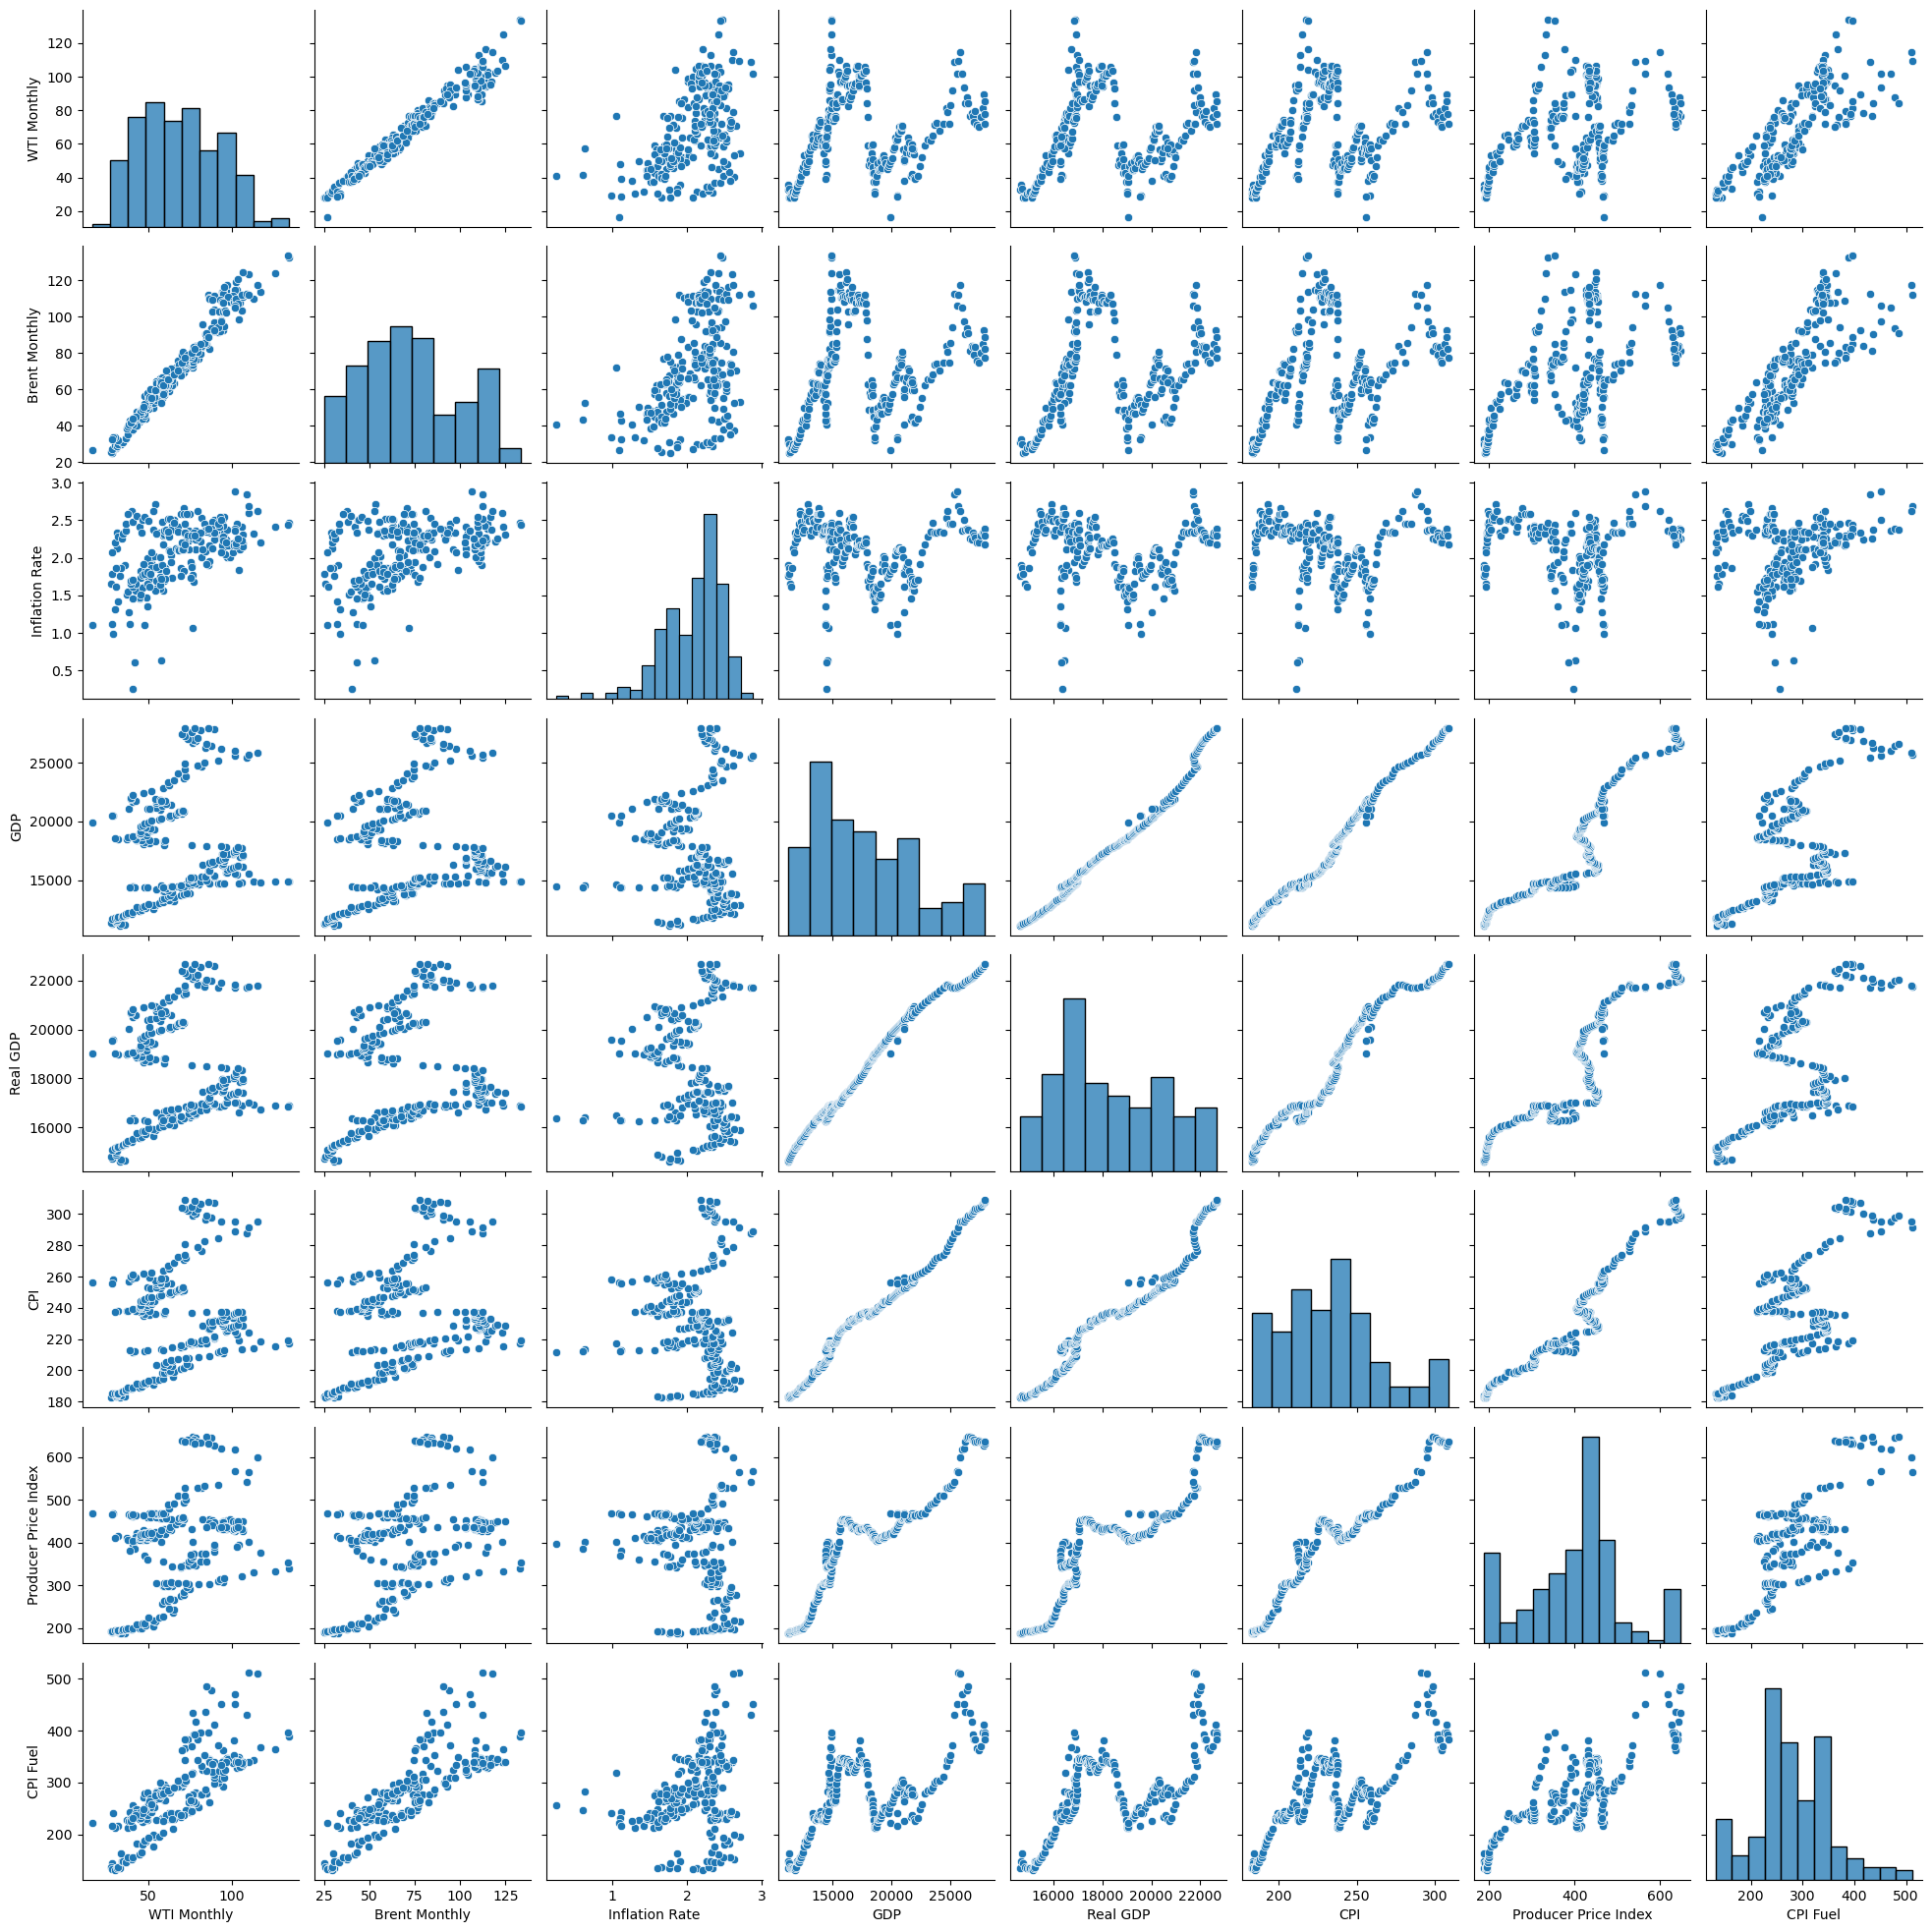

In [27]:
pair_rplot = sns.pairplot(wticombined_filled[['WTI Monthly', 'Brent Monthly','Inflation Rate','GDP', 'Real GDP', 'CPI', 'Producer Price Index' ,'CPI Fuel']])
plt.show()
pair_rplot.savefig('pair_rplot.png')

Boxplots

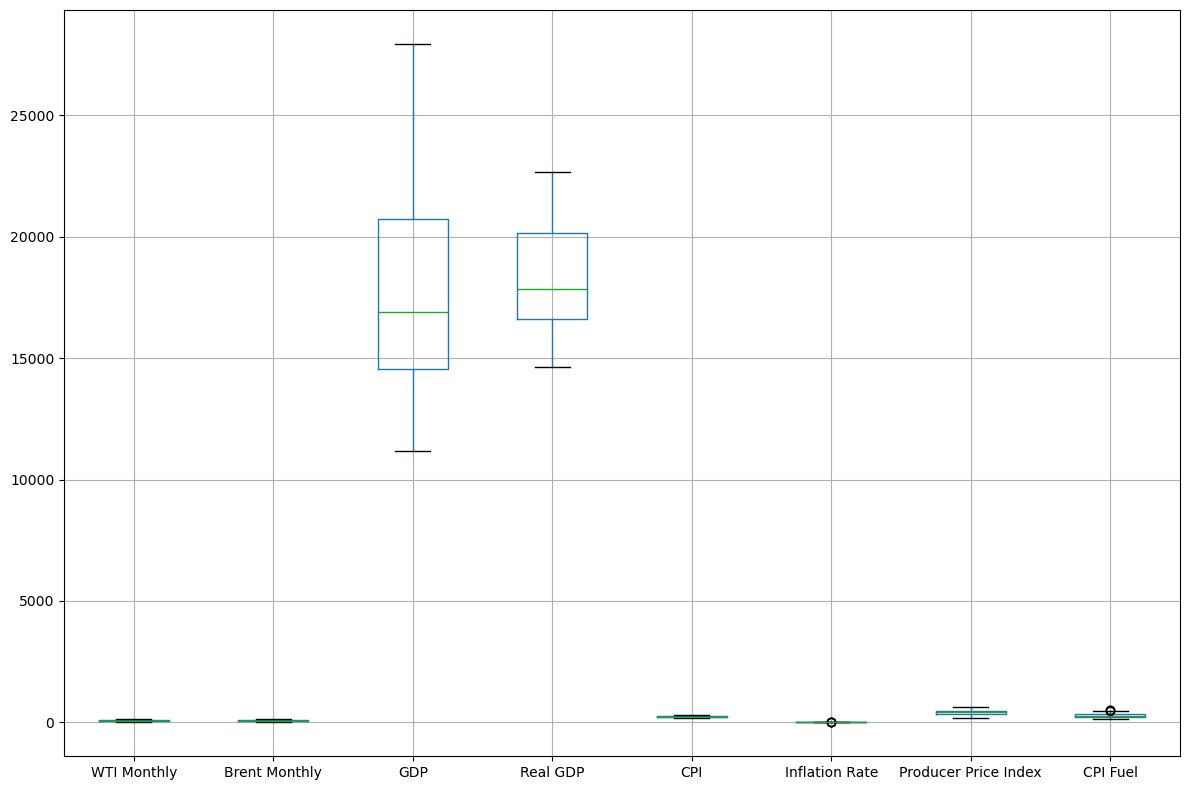

In [28]:
wticombined_filled.boxplot(figsize=(12, 8))
plt.tight_layout()
plt.show()


Plot box plots for the log-transformed variables


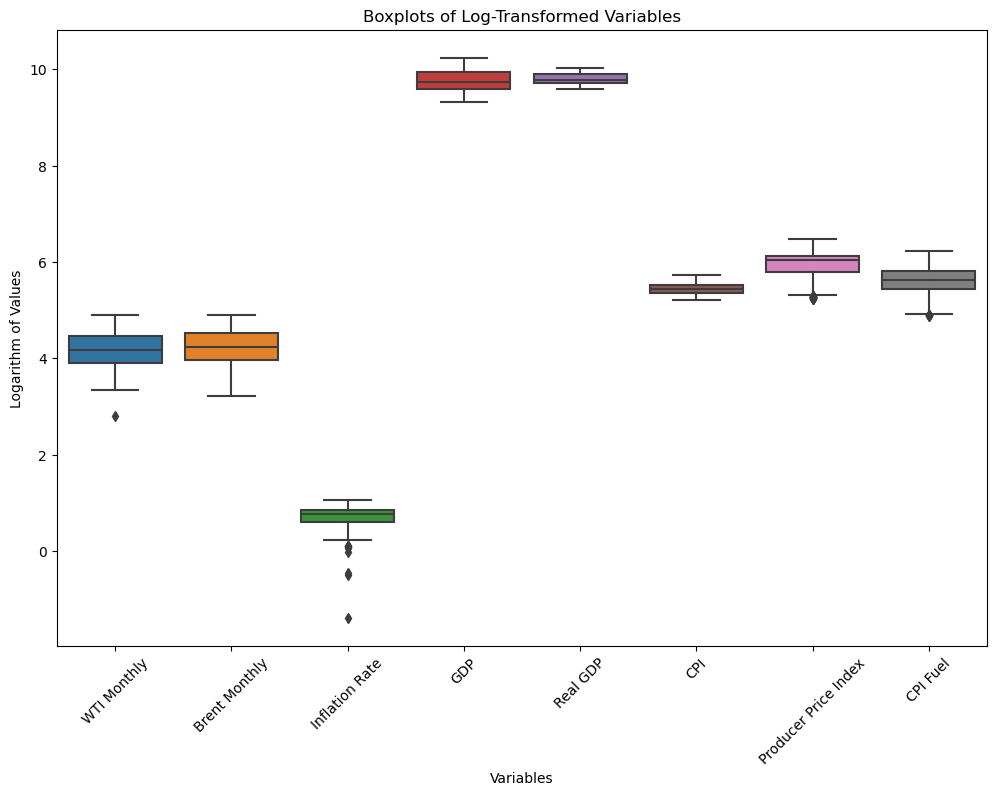

In [29]:
wticombined_log = np.log(wticombined_filled[['WTI Monthly', 'Brent Monthly','Inflation Rate','GDP', 'Real GDP', 'CPI', 'Producer Price Index', 'CPI Fuel']])


plt.figure(figsize=(12, 8))
sns.boxplot(data=wticombined_log)
plt.title('Boxplots of Log-Transformed Variables')
plt.ylabel('Logarithm of Values')
plt.xlabel('Variables')
plt.xticks(rotation=45)
plt.show()

Correlation Matrix

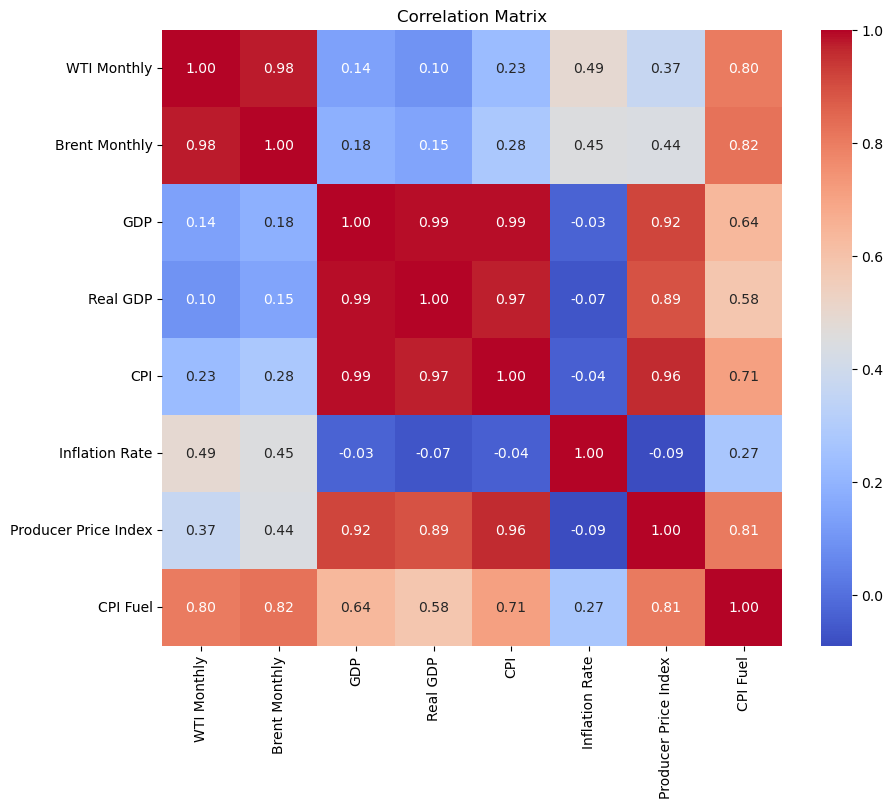

In [30]:
corr_matrix = wticombined_filled.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [31]:
# Generate summary of correlation coefficients
print("Summary of Correlation Coefficients:")
corr_matrix

Summary of Correlation Coefficients:


,WTI Monthly,Brent Monthly,GDP,Real GDP,CPI,Inflation Rate,Producer Price Index,CPI Fuel
WTI Monthly,1.000000,0.977231,0.139946,0.097811,0.228599,0.492641,0.368960,0.801020
Brent Monthly,0.977231,1.000000,0.184349,0.147267,0.279139,0.450066,0.440819,0.823869
GDP,0.139946,0.184349,1.000000,0.989873,0.990280,-0.033588,0.918518,0.635522
Real GDP,0.097811,0.147267,0.989873,1.000000,0.970932,-0.065318,0.890791,0.584961
CPI,0.228599,0.279139,0.990280,0.970932,1.000000,-0.041853,0.959650,0.708371
Inflation Rate,0.492641,0.450066,-0.033588,-0.065318,-0.041853,1.000000,-0.089070,0.270611
Producer Price Index,0.368960,0.440819,0.918518,0.890791,0.959650,-0.089070,1.000000,0.807017
CPI Fuel,0.801020,0.823869,0.635522,0.584961,0.708371,0.270611,0.807017,1.000000


In [32]:
data = pd.read_csv(r"data.csv")

In [33]:
time_series = data['WTI Monthly']

def check_stationarity(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(' ')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    if result[1] <= 0.05:
        print(' ')
        print("The time series is stationary.")
    else:
        print(' ')
        print("The time series is non-stationary.")

In [34]:
check_stationarity(time_series)

ADF Statistic: -3.2170372965417413
p-value: 0.019019433185769204
 
Critical Values:
   1%: -3.456780859712
   5%: -2.8731715065600003
   10%: -2.572968544
 
The time series is stationary.


In [35]:
differenced_series = time_series.diff().dropna()

In [36]:
check_stationarity(differenced_series)

ADF Statistic: -10.938756670847322
p-value: 9.412586377556244e-20
 
Critical Values:
   1%: -3.456780859712
   5%: -2.8731715065600003
   10%: -2.572968544
 
The time series is stationary.


In [37]:
p, d, q = (1, 1, 1)
model = ARIMA(time_series, order=(p, d, q))
results = model.fit()

In [38]:
y_preda = results.predict()
r2 = r2_score(time_series,y_preda)
mse = mean_squared_error(time_series,y_preda)
arima_result = ({'Model':'ARIMA', 'R2 Score':r2, 'Mean Squared Error':mse})
arima_result

{'Model': 'ARIMA',
 'R2 Score': 0.9312339432141831,
 'Mean Squared Error': 37.36885800698069}

In [39]:
ARIMA = pd.DataFrame({ 'y_test':time_series,'y_pred':y_preda}).sort_values(by='y_test', ascending=False)

In [40]:
x = wticombined_filled[['Brent Monthly' ,'Inflation Rate', 'CPI','Producer Price Index' , 'CPI Fuel','GDP', 'Real GDP']]
y = wticombined_filled['WTI Monthly']

In [41]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

In [42]:
result = pd.DataFrame(columns=['Model', 'R2 Score', 'Mean Squared Error'])

def score(model, x_train, x_test, y_train, y_test, model_name):
    global result
    model_instance = model.fit(x_train, y_train)
    y_pred = model_instance.predict(x_test)
    
    model_r2_score = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    result = result.append({'Model': model_name, 'R2 Score': model_r2_score, 'Mean Squared Error': mse}, ignore_index=True)
    return y_test, y_pred, model_name, model_r2_score, mse

In [43]:
models = [RandomForestRegressor(max_depth= 20, max_features= 'log2', min_samples_leaf= 1, min_samples_split= 2, n_estimators= 200), 
          KNeighborsRegressor(n_neighbors=1), 
          DecisionTreeRegressor(criterion = 'absolute_error'),
          GradientBoostingRegressor(n_estimators=1000)]

for model in models:
    model_name = type(model).__name__
    score(model, x_train, x_test, y_train, y_test, model_name) 

C:\Users\Ashin Johnson\AppData\Local\Temp\ipykernel_15088\115689089.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'Model': model_name, 'R2 Score': model_r2_score, 'Mean Squared Error': mse}, ignore_index=True)
C:\Users\Ashin Johnson\AppData\Local\Temp\ipykernel_15088\115689089.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'Model': model_name, 'R2 Score': model_r2_score, 'Mean Squared Error': mse}, ignore_index=True)
C:\Users\Ashin Johnson\AppData\Local\Temp\ipykernel_15088\115689089.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'Model': model_name, 'R2 Score': model_r2_score, 'Mean Squared Error': mse}, ignore_index=True)


C:\Users\Ashin Johnson\AppData\Local\Temp\ipykernel_15088\115689089.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'Model': model_name, 'R2 Score': model_r2_score, 'Mean Squared Error': mse}, ignore_index=True)


In [44]:
result = result.append(arima_result, ignore_index=True)
result = result.sort_values(by='R2 Score', ascending=False).set_index('Model')
result


C:\Users\Ashin Johnson\AppData\Local\Temp\ipykernel_15088\3372271617.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(arima_result, ignore_index=True)


,R2 Score,Mean Squared Error
Model,,
GradientBoostingRegressor,0.981953,10.633398
RandomForestRegressor,0.973228,15.773686
DecisionTreeRegressor,0.937132,37.041527
ARIMA,0.931234,37.368858
KNeighborsRegressor,0.918917,47.773792


In [45]:
models = [
    RandomForestRegressor(max_depth=20, max_features='log2', min_samples_leaf=1, min_samples_split=2, n_estimators=200),
    KNeighborsRegressor(n_neighbors=1),
    DecisionTreeRegressor(criterion='absolute_error'),
    GradientBoostingRegressor(n_estimators=1000)]

result_tables = {}

for model in models:
    model_name = type(model).__name__
    
    model_instance = model.fit(x_train, y_train)
    y_pred = model_instance.predict(x_test)
    
    table = pd.DataFrame({
        'y_test': y_test,
        'y_pred': y_pred,
    })

    result_tables[model_name] = table

random_forest = result_tables['RandomForestRegressor'].sort_values(by='y_test', ascending=False)
knn = result_tables['KNeighborsRegressor'].sort_values(by='y_test', ascending=False)
decision_tree = result_tables['DecisionTreeRegressor'].sort_values(by='y_test', ascending=False)
gradient_boosting = result_tables['GradientBoostingRegressor'].sort_values(by='y_test', ascending=False)

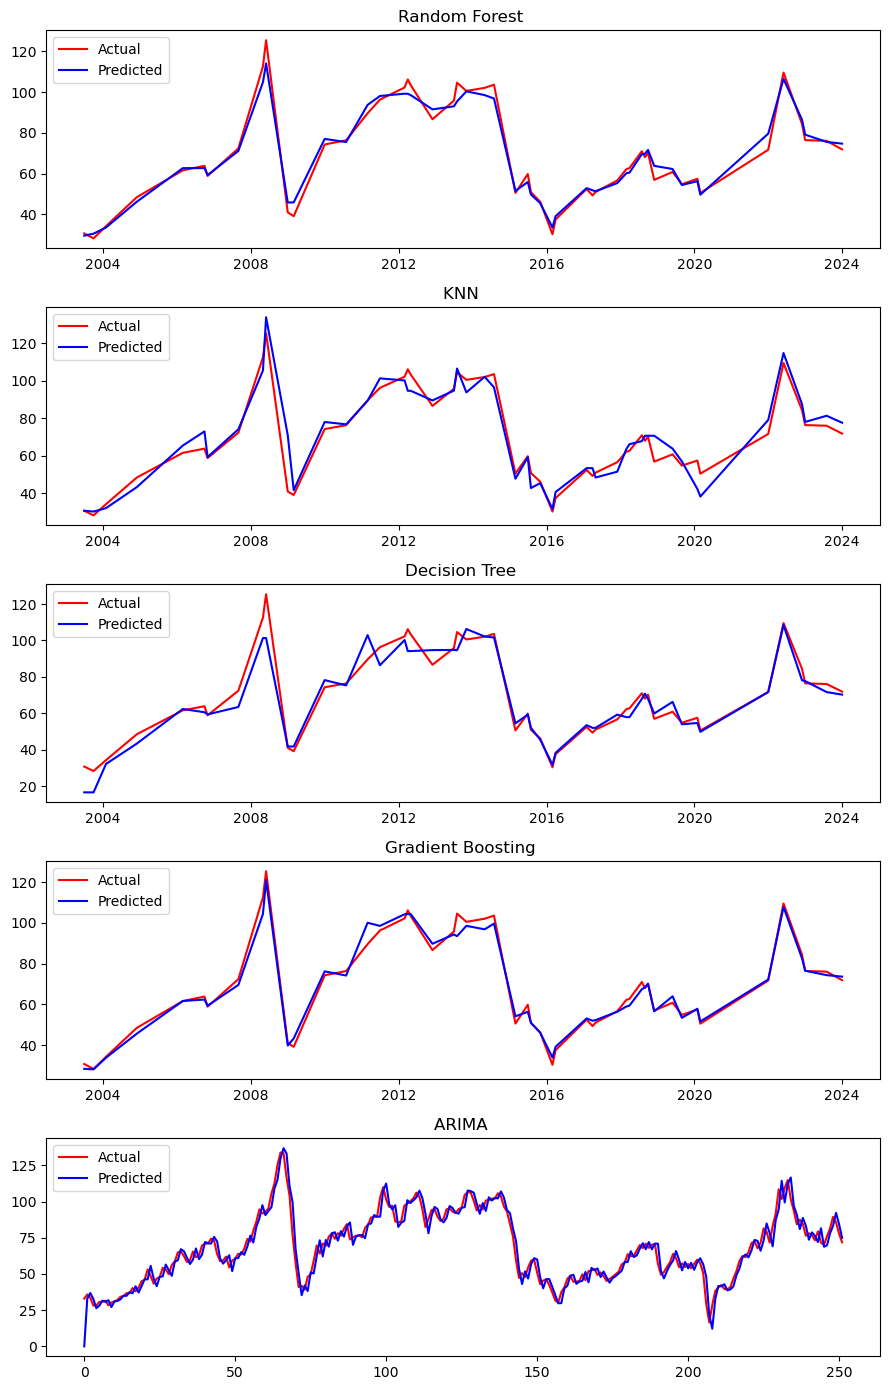

In [46]:
df = [random_forest, knn, decision_tree, gradient_boosting,ARIMA]

sorted_dfs = [model.sort_index() for model in df]

model_names = ['Random Forest', 'KNN', 'Decision Tree', 'Gradient Boosting','ARIMA']

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(9, 14))

for i, (sorted_df_i, model_name) in enumerate(zip(sorted_dfs, model_names), 1):
    ax = axes[(i - 1)]

    ax.plot(sorted_df_i.index, sorted_df_i['y_test'], label='Actual', color='red')
    ax.plot(sorted_df_i.index, sorted_df_i['y_pred'], label='Predicted', color='blue')
    ax.set_title(f"{model_name} ")
    ax.legend()

plt.tight_layout()
plt.show()

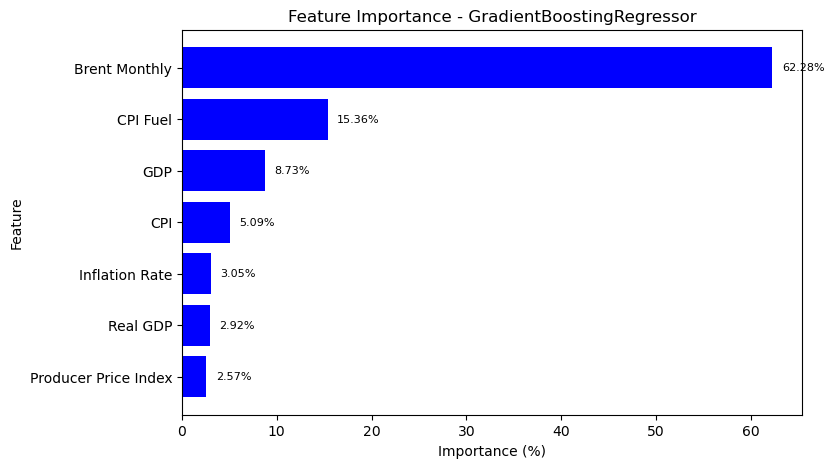

In [47]:
model = GradientBoostingRegressor(max_depth=20, max_features='log2', min_samples_leaf=1, min_samples_split=2, n_estimators=200)
feature_importances = model.fit(x_train, y_train).feature_importances_
total_importance = sum(feature_importances)
percentage_importance = (feature_importances / total_importance) * 100
sorted_indices = np.argsort(percentage_importance)[::1]
sorted_importances = percentage_importance[sorted_indices]
sorted_features = np.array(x_train.columns)[sorted_indices]
plt.figure(figsize=(8, 5))
bars = plt.barh(range(len(sorted_importances)), sorted_importances, tick_label=sorted_features, color='blue')
for bar, percentage in zip(bars, sorted_importances):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height() / 2, f'{percentage:.2f}%', ha='left', va='center', fontsize=8)
plt.xlabel('Importance (%)')
plt.ylabel('Feature')
plt.title(f'Feature Importance - {type(model).__name__}')
plt.show()